#  **Deep Learning Project**


Nicolas Tilquin & Guillaume Rigaud

In this project, we will do a quick review of two papers presenting the DC GAN and the Wasserstein GAN whose main goal was to improve the training stability of the original GANs presented by Goodfellow and al. in 2014 (available at https://arxiv.org/pdf/1406.2661.pdf) . We will finally present a more advanced architecture: the cycle GAN.  


On the implementation part, we will use Tensorflow to implement DC-GAN and generate digits learning from MNIST database.
We will then implement the Cycle GAN architecture and first translate from MNIST to USPS dataset. Finally we will use Matisse paintings that we scrapped on Wikiart.org in order to translate from photos to paintings.



In [4]:

WORK_ON_COLAB = True

if WORK_ON_COLAB:
  try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
  except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0
Found GPU at: /device:GPU:0


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 17 00:09:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   8741MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# packages and functions
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Flatten, Input, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow_addons.layers  import InstanceNormalization

from IPython.core.display import display as jupy_display
import numpy as np
import os
import time 
import h5py
import pickle

In [0]:
# google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
os.getcwd()
os.chdir('/content/drive/My Drive/DL_Project')   

In [0]:
# Mnist Data base 

(mnist_train, labels_train), (mnist_test, labels_test) = tf.keras.datasets.mnist.load_data()

from skimage.transform import resize

mnist_train = resize(mnist_train, (mnist_train.shape[0], 64, 64, 1), preserve_range=True).astype("float32")
mnist_train = (mnist_train - 127.5) / 127.5 # scale between [-1,1]

print(mnist_train.shape)


(60000, 64, 64, 1)


# **0. Reminder on GAN**


GANs were inspired from game theory: instead of maximizing the likelihood in a large space (where the KL divergence could be equal to +infinity if there are regions where the density has no mass), the problem is set as a competitive game beetween two models. A generator samples data from random noise and tries to fool a discriminator whose goal is to distinguish true datapoints from generated datapoints. The training process allows the generator to learn from the discriminator : at each step, the generator produces more realistic datapoints thanks to the informatioin provided by the discriminator. At the end of the learning process, the discriminator shouldn't be able to distinguish fake and real data. On the theoretical point of vue it is interesting to replace KL minimization by adversial Game. 


GANs are used for generating realistic data. Most applications have been for images. For example the StackGan model takes a text description of birds and generates a corresponding image. GANS can generate image from simple representation (Pix2pix). They can transfer style from image to image (image to image translation, face to emoji, horse to zebra, unsupervised methods since images aren't coupled).
GAN's can also be used to generate training dataset, for imitation learning (in physics : learn the outcome distribution of an experiment) or to avoid Monte Carlo simulatioins of expensive experiments. 


A key objectiv in image processing is to downsample image size. GAN's are a way to downsample an image : to generate an image with a gan, we only need a noise vector to pass through the generator. GAN learn a mapping that links the input vector space to a larger image space.  There exists other methods such as AutoEncoders. 

# **1. DC-GAN**




## **1.1 Summary of "Unsupervised Representation Learning with Deep Convolutional Generative Adversiaol Networks"**


*Unsupervised Representation Learning with Deep Convolutional Generative Adversiaol Networks*, Alec Radford, Luke Metz, Soumith Chintala (2016) available at https://arxiv.org/abs/1511.06434


DC GAN is a type of GANs characterized by a specific architecture.  The following architecure is assumed to make GANs more stable  :
- replace deterministic spatial pooling functions with strided convolutions :  the network can learn its own spatial downsampling
- Use batchnorm in both the generator and the discriminator
- use ReLu activation in generator for all layers except output, which uses Tanh
- Use LeakyReLU activation in the discriminator for all layers 


To get from a small feature map to a wider an taller image space, we
increase the size of the image with transposed convolution operator with stride greater than 1. 


Here are some usefull link that explain both transposed convolution https://www.youtube.com/watch?v=sX_AxtB6CHI and batchnormalization https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c



We found the paper really interesting in terms of experimental experiences that were described and let us get a more precise idea of the Deep Learning research field. 
- Evaluating the quality of representation of a (trained) GAN can be done by using the Discriminator's convolutional featyres from all layers, maxpooling each layers representation and then, training a classifier on top of these features. The accuracy of the classifier is a good indicator of the GANs ability to extract features from images. 

- Adressing the memorization aspect :  GANs have indeed millions of parameters.One could assume that GANs only "memorize" input images and then selects them randomly to generate images. But the authors of the paper gave examples showing that the transition in latent space were smooth and not sharp, meaning that there shouldn't be memorization :  the lattent space is learned to produce realistic images. 

- Training GANs is very difficult : parameters such as learning rate used for the training are provided. We tried changing this a bit during the implementation and didn't get good results. We would recommend following the paper's advice for training. 

- understanding of the latent space with vector arithmetic. Some experiment showed that vector arithmetic worked quite well when averaging vectors. For example, doing the following arithmetic on the lattent space : man with glass - man without glass + woman without glass would give a woman with glasses when fed to the generator, as long as each vector is an average of samples with the corresponding caracteristics. 


This paper provides a more stable architecture based on convolutional networks and gives a series of guidelines to improve GANs stability. Features extracted by GANs can be used for other tasks such as classification. Vector aritmetic on the lattent space is a really interesting aspect that could enable to use GANs generate an image with constraints. For example, in video games, landscape with fixed caracteristics could be generated by an GAN using vector arithmetic. 

## **1.2. Implementation**

We will use functions and classes from the `HelpersDCGAN.py` script. 


### **Discriminator**

The discriminator is based on strided convolutions and Leaky ReLU activation functions. Batchnormalization is also used in the Discriminator. Only the last layer is a fully connected one in order to get a sigmoid output for the discriminator to classify images. This sigmoid function enforces the output to be between 0 and 1 and can thus be interprated as a porbability


We follow the recommendation and use Batchnorm and Relu after each convolution

We will use the following architecture for the Discrimator. We jsut adapted the input layer to our problem 



In [0]:
from HelpersDCGAN import DCDiscriminator
discriminator = DCDiscriminator()
discriminator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 128)       2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0   

### **Generator**


### **Generator**


As in classic GANs, the input of the generator is a random noise vector and its output is an image. The input is first fully connected to a narrower and deeper layer. Then, transposed convolutions are used to gradually upsample from the input layer. The resulting layers are stacked until one gets a layer which is of the size of the real images. As recommended in the paper, there are no hidden fully connected or deterministic pooling layers but only strided convolutions. This allows the generator to “learn its own spatial downsampling” (contrary to Fully Connected GANs). In order to fasten the training and prevent grandient from vanishing we used LeakyReLU activations instead of ReLU (because of their bounding property and non null property) except for the output layer which uses a Tanh function, in order to get pixels of images between -1 and 1. For stability purposes, batch normalization is also used to scale all layers except the last one (each unit has mean 0 and unit variance).



In [0]:
from HelpersDCGAN import DCGenerator, get_noise, plot_generated_images
generator = DCGenerator()
generator.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 1, 100)]       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 1024)        1639424   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         8389120   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 512)         0   

init (25, 1, 1, 100)
Fake images (25, 64, 64, 1)


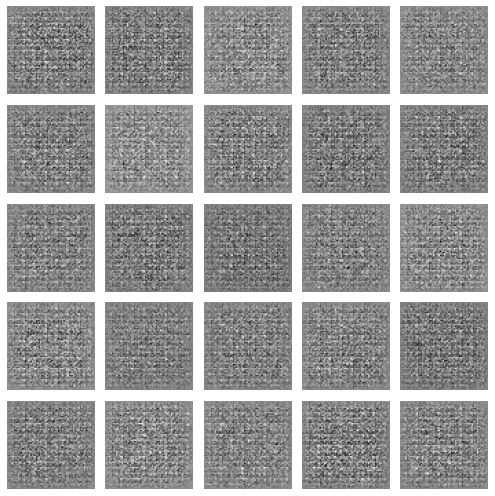

In [0]:
# quick example : 
noise = get_noise(25, nz = 100)
print("init", noise.shape)
fake_images = generator(noise)
plot_generated_images(fake_images, figsize = (7,7), save = False)
print("Fake images", fake_images.shape)

In [0]:
d_output = discriminator(fake_images)
print("Predictions", d_output.shape)
d_output

Predictions (25, 1)


<tf.Tensor: shape=(25, 1), dtype=float32, numpy=
array([[ 1.29020220e-04],
       [ 1.31783963e-04],
       [ 1.51527813e-04],
       [ 1.79152994e-04],
       [ 1.08875429e-04],
       [ 1.62918368e-04],
       [ 1.14313872e-04],
       [ 5.38046952e-05],
       [ 1.13390895e-04],
       [ 1.21647266e-04],
       [ 1.10081804e-04],
       [ 1.39685362e-04],
       [ 1.70394094e-04],
       [ 7.40463656e-05],
       [ 9.87624080e-05],
       [ 1.72607426e-04],
       [ 1.60196505e-04],
       [ 1.38648975e-04],
       [ 1.23392441e-04],
       [ 1.07236207e-04],
       [ 8.26039104e-05],
       [ 1.11102410e-04],
       [ 1.23565813e-04],
       [-1.33481626e-06],
       [ 3.78742188e-05]], dtype=float32)>

### **Adversial Model**

We now train the GAN taking as input our two models.


In [0]:
mnist_dataset = tf.data.Dataset.from_tensor_slices(mnist_train).shuffle(60000).batch(125, drop_remainder=True)

====== Epoch  0 ======

Discriminator: 0.4844728112220764, Generator: 5.135162830352783
Time for epoch 1 is 108.28721261024475 sec
====== Epoch  1 ======

Discriminator: 0.4866434335708618, Generator: 2.986737012863159
Time for epoch 2 is 105.03461241722107 sec
====== Epoch  2 ======

Discriminator: 0.5100061893463135, Generator: 2.7387166023254395
Time for epoch 3 is 104.7972047328949 sec
====== Epoch  3 ======

Discriminator: 0.38438647985458374, Generator: 3.3844516277313232
Time for epoch 4 is 104.95647430419922 sec
====== Epoch  4 ======

Discriminator: 0.3928578495979309, Generator: 3.458714246749878
Time for epoch 5 is 104.79629015922546 sec
====== Epoch  5 ======

Discriminator: 0.4539533853530884, Generator: 3.291900873184204
Time for epoch 6 is 104.96786689758301 sec
====== Epoch  6 ======

Discriminator: 0.3143053352832794, Generator: 3.8553082942962646
Time for epoch 7 is 104.99734306335449 sec
====== Epoch  7 ======

Discriminator: 0.32235801219940186, Generator: 3.8077094

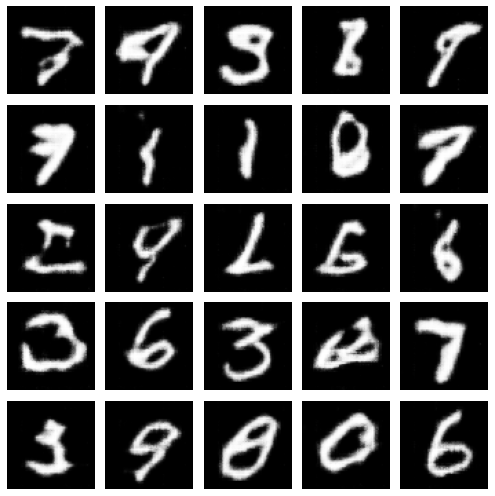

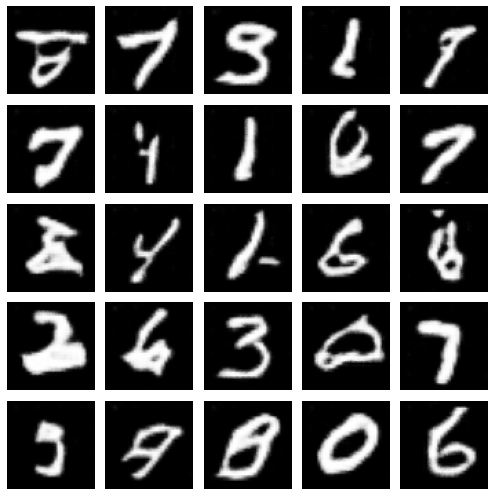

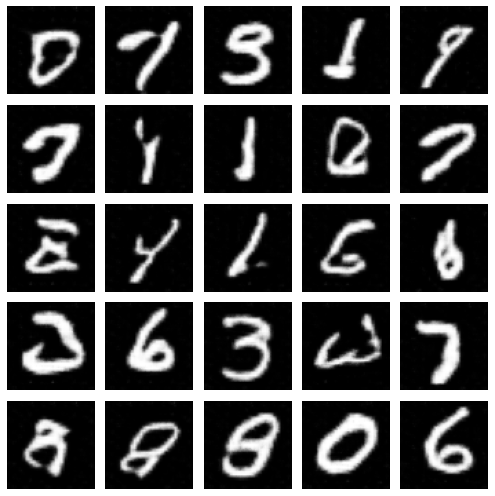

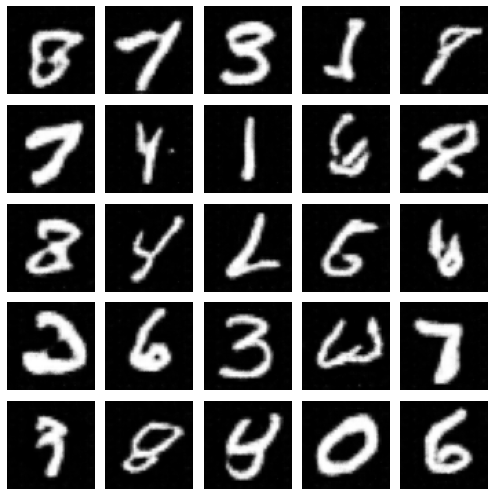

In [0]:
from HelpersDCGAN import DCGAN

gan = DCGAN(generator, discriminator)

gan.train(mnist_dataset, epochs = 20)

In [0]:
## uncomment the followiing lines if you want to save again the models
#gan.generator.save('generator.h5')
#gan.discriminator.save('discriminator.h5')


In [0]:
loaded_generator = tf.keras.models.load_model('DC_generator.h5')
loaded_discriminator = tf.keras.models.load_model('DC_discriminator.h5')

<class 'tensorflow.python.framework.ops.EagerTensor'>


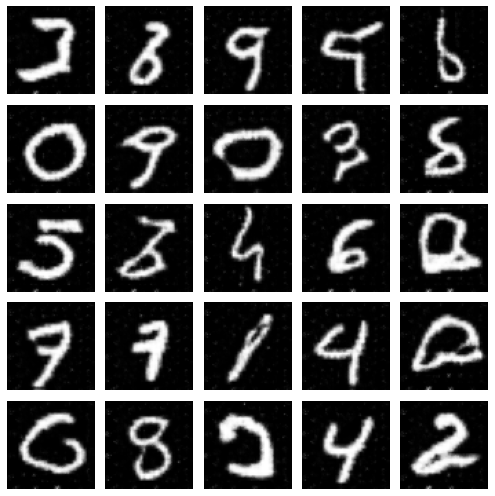

In [0]:
fake_images = loaded_generator(noise)
print(type(fake_images))
plot_generated_images(fake_images, figsize = (7,7), save = False)

# **2. Wasserstein GAN**
 


*Wasserstein GAN*, Martin Arjovsky, Soumith Chintala, Léon Bottou (2017) available at https://arxiv.org/abs/1701.07875 



### 2.1 Scope of the paper
The Wasserstein Generative Adversarial Network (GAN) is an extension of the GANs that were created by Goodfellow, introduced to improve the stability of the model during the learning phase and to correlate the loss function with the quality of the generated image.
Recall that the GAN is composed of two adversary networks: the discriminator must distinguish between the generated images $\mathbb{P}_{\theta}$ and the true images $\mathbb{P}_{r}$, while the generator has to trick the discriminator by generating images as close as possible to the real ones. Consequently, we see the interest of the notion of distance here, between these two probability distributions to update theta in order to get as close as possible the true distribution.
The Wasserstein distance is often used in optimal transport in order to compute the distance between two mass (or probability distributions) on a metric space. 






### 2.2 Problem statement
This paper addresses an unsupervised problem in which we ask how to learn a probability distribution $\mathbb{P}_{r}$.
The classical solution to this problem is to define a family of parametric density $\mathbb{P}_{\theta \in \mathbb{R^d}}$ and find the one that maximizes the likelihood of our data. One of the main drawbacks of this method is that the probability may not be defined if the intersection of the supports of both distributions is negligible, which is the case when the parametric distribution is lower than the distribution we wishes to obtain. One of the solutions consists in defining a random variable $\mathcal{Z}$ with a fixed distribution $\mathcal{p(z)}$ and the passed to a parametric function $\mathcal{g_{\theta}}: \mathcal{Z} \to \mathcal{X}$ which follows the distribution $\mathbb{P}_{\theta}$. We are looking for the $\theta$ such that our $\mathbb{P}_{\theta}$ and $\mathbb{P}_{r}$ are very close.
It is on this varied question of "measuring the distance" that the paper wants to shed light. In the "classical" GANs, two types of divergence are used:

* $\mathit{KL-divergence}$ 

$$KL(\mathbb{P}_{r} \| \mathbb{P}_{g}) = \int \log(\frac{\mathcal{P}_{r}(x)}{\mathcal{P}_{g}(x)})\mathcal{P}_{r}(x)d\mu(x)$$

* $\mathit{JS-divergence}$ 
$$JS(\mathbb{P}_{r}, \mathbb{P}_{g}) = KL(\mathbb{P}_{r} \| \mathbb{P}_{m}) + KL(\mathbb{P}_{g} \| \mathbb{P}_{m})$$

In practice, GANs have less difficulty in optimizing the discriminator with respect to the generator. Minimized objective function of the GAN with an optimal discriminator is equivalent to minimizing the JS divergence. If the image generated at a very distant q-distribution of the true P-distribution, the generator learns almost nothing. As we said before, Arjovsky and al. proposes in their paper of 2017, to add noise in the image generation to stabilize the model during the training phase.
This paper proposes a new alternative cost function that uses the Wasserstein distance.


### 2.3 Different distances
There are several ways to measure the distance between two distributions. The paper compares 4 elementary distances and divergences between two probability distributions $\mathbb{P}_{r}$, $\mathbb{P}_{g}$. Among these different methods, there is one called **Earth-Mover distance or Wassertein 1**:
$$
W(\mathbb{P}_{r}, \mathbb{P}_{g}) = \inf_{\gamma \in \Pi(\mathbb{P}_{r}, \mathbb{P}_{g})} \mathbb{E}_{(x, y) \sim \gamma}[\parallel x - y \parallel]$$
After recalling the formulas for each of them, he takes an example where he shows that each of these four distances and divergences with the exception of
of that of EM have loss functions that are not continuous although the supports of these two distributions are common. Indeed, the authors insist on the notion of *manifold* which is a topological space that locally resembles the Euclidean space near each point. 
Precisely, when this Euclidean space is of dimension n, the manifold is called n-manifold. 

Arjovsky et al. (n.b in the 2017 paper) examined the problem of the supports of $\mathbb{P}_{r}$ and $\mathbb{P}_{g}$ based on small manifolds. They show that these small manifolds contribute to GAN instability. Given that  $\mathbb{P}_{g}$ and  $\mathbb{P}_{r}$ rest both on small manifolds, they are unlikely to have common supports. Therefore, when the support are disjointed, there is always a
A discriminator capable of perfectly separating the generated images from the real images.
Moreover, the dimensions of some real dataset can, at first sight seem to be high, but it's just a trick. The authors found in this case, that the manifolds are concentrated in a space of smaller dimension. Let's take an example, when we
have defined a goal to our algorithm as cat recognition, the image has a set of restrictions to follow such as the presence of whiskers, two eyes...
These restrictions keep images aways from the possibility of having a high-dimensional free form.
The authors show that the Wasserstein distance is smaller than the JS distance and prove under certain conditions that the loss function is continuous in theta everywhere and is differentiable almost everywhere.
Only the distance EM is reasonable, as the others are not suitable when trying to switch from a small space to an large space (which is the case for image generation).
Therefore, this loss function can be used to calculate the gradient descent on neural networks.

### 2.4 Wasserstein GAN
However the authors prove that it is impossible to exhaust all possible joint distributions in $\Pi(\mathbb{P}_{r}, \mathbb{P}_{g})$ to compute $\inf y \sim \Pi(\mathbb{P}_{r}, \mathbb{P}_{g})$. They solve the problem based on the Kantorovich-Rubinstein duality to :
$$
W(\mathbb{P}_{r}, \mathbb{P}_{\theta}) = \sup_{\|f\|_{l}\leq 1} \mathbb{E}_{x \sim \mathbb{P}_{r}}[f(x)] - \mathbb{E}_{x \sim \mathbb{P}_{\theta}}[f(x)] 
$$
where the supremum is over all the 1-Lipschitz functions $\mathcal{f}: \mathcal{X} \to \mathbb{R}$.
So to calculate the Wasserstein distance, we just need to find a 1-Lipschitz function.
When training Wasserstein GANs, the Wasserstein distance is approximated by searching for the supremum over the set of 1-Lipschitz functions. In the following algorithm, we see that the clipping step enforces the function to be Lipschitz. The paper leaves this subject of enforcing Lipschitz constraint into Neural Network for further investigation. 

![source : WGAN alorithm](https://drive.google.com/uc?id=1d_6MxhhVh1B5J2Z1xY4akdrn4LudeQ0q)


# **3. Cycle GAN** 



## **3.1 Key ideas behind the _Unpaired Image-to-image Translation using Cycle-Consistnt Adversial Networks_ paper**

_Unpaired Image-to-image Translation using Cycle-Consistnt Adversial Networks_ Jun-Yan Zhu* Taesung Park* Phillip Isola Alexei A. Efros (2018) available at https://arxiv.org/pdf/1703.10593.pdf (* indicates equal contributions)



The goal behind Cycle GANs is to learn the characteristics of an image collection and figure out how these characteristics could be translated into another image collection. It is a particular case of image-to-image translatioin that doesn't require paired training examples  

 Image-to-image translation is a class of vision and graphics problem whose goal is to learn the mapping between an input image and an output image, using a training set of paired images. For many taks, it is hard to find perfectly paired images. 

 Cycle-GAN tries to capture correspondances between a high level appearance of structures that are two datasets, whereas other methods such as Neural style transfer between two specific images by combining the content of an image with the style of another. 

Cycle GAN enable learning a mapping from one domain $X$ to another domain $Y$ and thus doesn't require having perfectly paired training images. (_Domains of application : artistic style transfer, object transfiguration, season transfer, photo enhancement.._)


>Formally the goal is to learn a mapping $G : X \rightarrow  Y $ such that the distribution of images from $G(X)$ is indistinguishable from the distribution of $Y$ using an adversial loss (i.e an adversary can't tell whether the images is sampled from $Y$ or from $G(X)$ ). This setting is insufficient since it is highly under-constrained :  the mapping $G$ could for example produce the same image output for each input (mode collapse problem). This first translation doesn't guarantee that an individual input $x$ and its output $y$ are paired in a meaningfull way. There are indeed infinitely many mappings $G$ that will induce the same distribution over $G(X)$. 

> To avoid this issue, the translation should be "cycle consistent". A nice example provided in the article is langage translation: if we translate a sentence from English to French, and then translate it back to English, we expect to get the original English sentence. This cycle consistency avoids all English sentences to match the same French sentence. Therefore, the inverse mapping $ F : Y \rightarrow X$ is intruduced to bring cycle consistency loss to enforce $ F(G(Y)) \approx X $ (and vice versa $ G(F(X)) \approx Y $). Combining the first adversial loss with this cycle consistent loss enables to attain the full objective of unpaired image-tot-image translation. 




> ![source : Unpaired Image-to-image Translation using Cycle-Consistnt Adversial Networks](https://drive.google.com/uc?id=1GeeJ0T1mercjrXKbld-Q84V37J4yOoo9)
source : _Unpaired Image-to-image Translation using Cycle-Consistnt Adversial Networks_, page 3

## Loss equations 


Classic Adversial Loss 
$$
\mathcal{L}_{GAN}(G, D_{y}, X, Y) = \mathbb{E}_{y \sim p_{data}(y)}[\log D_{Y}(y)] + \mathbb{E}_{x \sim p_{data}(x)}[\log(1 - D_{Y}(G(x))]
$$

Cycle consistency Loss 
$$
\mathcal{L}_{cyc}(G, F) = \mathbb{E}_{x \sim p_{data}(x)}[\|F(G(x)) - x\|_{1}] + \mathbb{E}_{y \sim p_{data}(y)} [\|G(F(y)) - y\|_{1}] 
$$

Full objective : parameter $\lambda$
$$
\mathcal{L} (G, F, D_{X}, D_{Y}) = \mathcal{L}_{GAN} (G, D_{Y}, X, Y) + \mathcal{L}_{GAN} (F, D_{X}, Y, X) + \lambda \mathcal{L}_{cyc} (G, F)
$$
where $\lambda$ controls the relative importance of the two objectives. 

We aim to solve:
$$
G^{*}, F^{*} = arg \min_{G, F} \max_{D_{X}, D_{Y}} \mathcal{L} (G, F, D_{X}, D_{Y})
$$

## **3.2 Quick application : From Mnist to Usps dataset**

Instance Normalization is used instead of BatchNormalization.  A good illustration allowing to distinguish those normalizations is available here : https://www.tensorflow.org/addons/tutorials/layers_normalizations


We keep the same nomenclature as in the paper, here X is Mnist database and Y is Usps. G goes from the space of X to the space of Y and F does the backward path : from Y space to X space. 



In [0]:
from numpy.random import randint

# 1000 images and 40 epochs should be enough

n_samples = 1000
idx = randint(0, mnist_train.shape[0], n_samples) # we don't use all 60 000 images, we use only 10 000 randomly picked
mnist_train = resize(mnist_train[idx], (n_samples, 128, 128, 1), preserve_range=True).astype("float32")

In [0]:
path = 'usps.h5'
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        usps_train = train.get('data')[:]
        #y_tr = train.get('target')[:]
        test = hf.get('test')
        usps_test = test.get('data')[:]
        #y_te = test.get('target')[:]

from skimage.transform import resize

print("shape before" , usps_train.shape)
usps_train = resize(usps_train.reshape(usps_train.shape[0],16,16,1), (usps_train.shape[0], 128, 128, 1), preserve_range=True).astype("float32")
usps_train = usps_train*2 - 1 # scale between [-1,1], between [0,1] before
print("shape after", usps_train.shape)
idx = randint(0, usps_train.shape[0], n_samples)
usps_train = usps_train[idx,:,:,:]
print("shape sampled", usps_train.shape )

shape before (7291, 256)
shape after (7291, 128, 128, 1)
shape sampled (1000, 128, 128, 1)


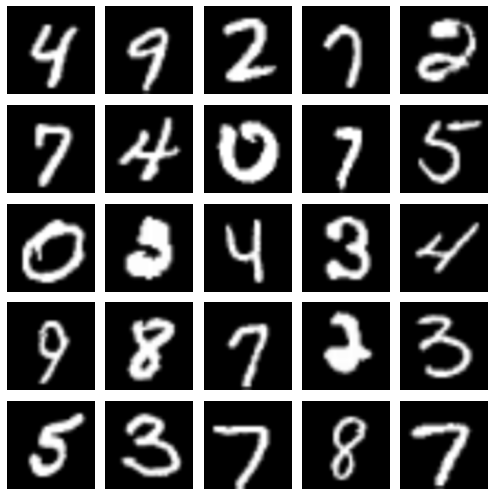

In [0]:
from HelpersCycleGAN import plot_generated_images
   
plot_generated_images(mnist_train[0:25,:,:,:])


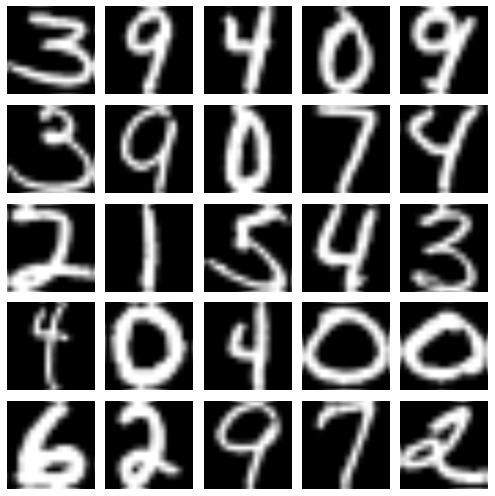

In [0]:
plot_generated_images(usps_train[0:25,:,:,:])


The Mnist digits are smaller. The Usps digits take more place on the square. USPS image quality is lower due to the original image size. 

In [0]:
from  HelpersCycleGAN import CycleGenerator, CycleDiscriminator

generator_g = CycleGenerator((128,128,1), n_resnet = 6) #only 6 resnet blocks for this simple problem 
generator_f = CycleGenerator((128,128,1), n_resnet = 6)

discriminator_x = CycleDiscriminator((128,128,1))
discriminator_y = CycleDiscriminator((128,128,1))


In [0]:
discriminator_x.summary()
discriminator_x(usps_train[0:25,:,:,:]).shape 

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_80 (I (None, 32, 32, 128)       256       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 16, 16, 256)       5245

TensorShape([25, 8, 8, 1])

In [0]:
generator_f.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 128, 128, 64) 3200        input_8[0][0]                    
__________________________________________________________________________________________________
instance_normalization_62 (Inst (None, 128, 128, 64) 128         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 128, 128, 64) 0           instance_normalization_62[0][0]  
____________________________________________________________________________________________

In [0]:
#BATCH of Size 1 as in the paper, we take only 1000 images to train the model 
n_samples = 1000
mnist_data = tf.data.Dataset.from_tensor_slices(mnist_train[0:n_samples,:,:,:]).shuffle(n_samples).batch(1)
usps_data = tf.data.Dataset.from_tensor_slices(usps_train[0:n_samples,:,:,:]).shuffle(n_samples).batch(1)

fixed_mnist = mnist_train[0:25,:,:,:] # for plot progression


4 losses. : 

- Adversarial loss (L2 or mean squared error)
- Identity loss (L1 or mean absolute error)
- Forward cycle loss (L1 or mean absolute error)
- Backward cycle loss (L1 or mean absolute error)

A regularization called identity mapping loss can be added. It is indeed recommended in the paper (section 5.2) to introduce this additional loss to encourage the mapping to preserve color composition between the input and the output. It will be usefull when working with paintings. 

In [0]:
from HelpersCycleGAN import CycleGAN
cycle_gan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y)

cycle_gan.train(train_x=mnist_data, train_y=usps_data, fixed_x=fixed_mnist,
                regularization=False, LAMBDA = 10, epochs=20, interval_save = 2, 
                checkpoint_dir = './cycletraining_checkpoints',
                title_g = "cyclegan_generated_image", 
                title_f = "cyclegan_back_generated_image")


====== Epoch  0 ======
..........
Time for epoch 0 is 243.73012852668762 sec
Discriminator y: 0.2620913088321686 , Generator G: 12.947603225708008, Discriminator x: 0.07772055268287659, Generator F: 16.987234115600586
====== Epoch  1 ======
..........
Time for epoch 1 is 203.29093956947327 sec
====== Epoch  2 ======
..........
Time for epoch 2 is 202.85640859603882 sec
Discriminator y: 0.06870511174201965 , Generator G: 10.548852920532227, Discriminator x: 0.00029928379808552563, Generator F: 15.05481243133545
====== Epoch  3 ======
..........
Time for epoch 3 is 203.07943034172058 sec
====== Epoch  4 ======
..........
Time for epoch 4 is 203.0511474609375 sec
Discriminator y: 0.07431627064943314 , Generator G: 8.917428016662598, Discriminator x: 0.2741858959197998, Generator F: 6.721585273742676
====== Epoch  5 ======
..........
Time for epoch 5 is 203.08794045448303 sec
====== Epoch  6 ======
..........
Time for epoch 6 is 204.6643443107605 sec
Discriminator y: 0.09144426882266998 , 

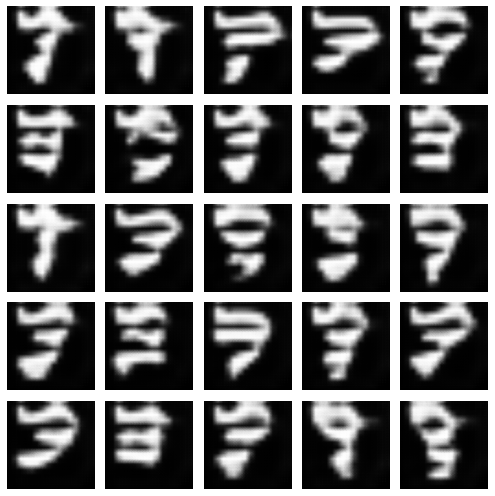

In [0]:
fixed_mnist = mnist_train[25:50,:,:,:] # for plot progression

cycled_images = cycle_gan.generator_g(fixed_mnist)
cycle_gan.plot_generated_images(images = cycled_images, epoch=0, save=False)


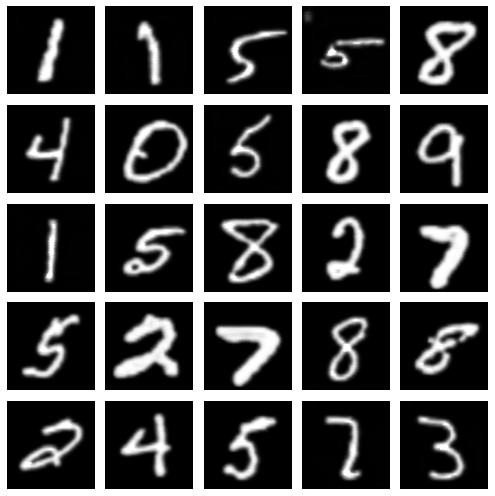

In [0]:
back_cycle = cycle_gan.generator_f(cycle_gan.generator_g(fixed_mnist))
cycle_gan.plot_generated_images(images = back_cycle, epoch=0, save=False)


In [0]:
cycle_gan.generator_f.save('generator1_f.h5')
cycle_gan.generator_g.save('generator1_g.h5')

cycle_gan.discriminator_x.save('discriminator1_x.h5')
cycle_gan.discriminator_y.save('discriminator1_y.h5')


# **Conclusion** 

Working on this project, we learned a lot about the Deep Learning research field. 
On a theoretical point of vue, we brought nothing new to the field but this project was the occasion to become more familiar with DL and espacially GANs, implement some already existing architecture and play around with them on a very simple example. Reading papers, we got more insight on the DL research field. We discovered that DL research is based a lot on experiment and benchmarking results encountered some practice to benchmark models. 


At first we didn't understand why so many papers talked about new architectures. But the implementation part of the project quickly made us understand why: it is hard to find an architecture that generalize well. 


Here are some informal feedback about how we proceeded when we started implementing some GANs. 
At the very first we tried to build our own architectures. What is really frustrating about DL is that you can't reverse ingineer very fast: each training takes a lot of time to complete, so when you made a mistake or tried an architecture it takes a long time to figure it out. Tunning parameters such as the learning rate could take some time and trying other architectures even more. Another problem we encountered was that with GANs you never know whether your model is completely stuck or if letting it train longer could help. It is always a dilema to stop your training or to keep going. 


Finally, we decided to use exactly the architectures provided in research papers or some already working (found on google colab tutorials for example). This part was less exciting since it was just the implementation of existing and working architecture. We have to admit that even on a simple dataset such as mnist it is always mind blowing to see the generated images. Considering a simple problem as Mnist, we are aware that the architecture we used overkill the problem (an FCGAN with far less parameters could work instead of a DCGAN). For further readings it would be interesting to see if there are papers linking the complexity of a problem to the most simple architecture we could use to tackle this problem. 



# **Appendix :  Cycle GAN on artistic examples** 

In the `Cycle_GAN_Paintings` folder, you will find the 'fit_CycleGAN' notebook that we used to train a CycleGAN on Matisse paintings that we scrapped on wikiArt. 

Here are some results that we got : 


In [0]:
os.chdir('/content/drive/My Drive/DL_Project/Cycle_GAN_Paintings')   

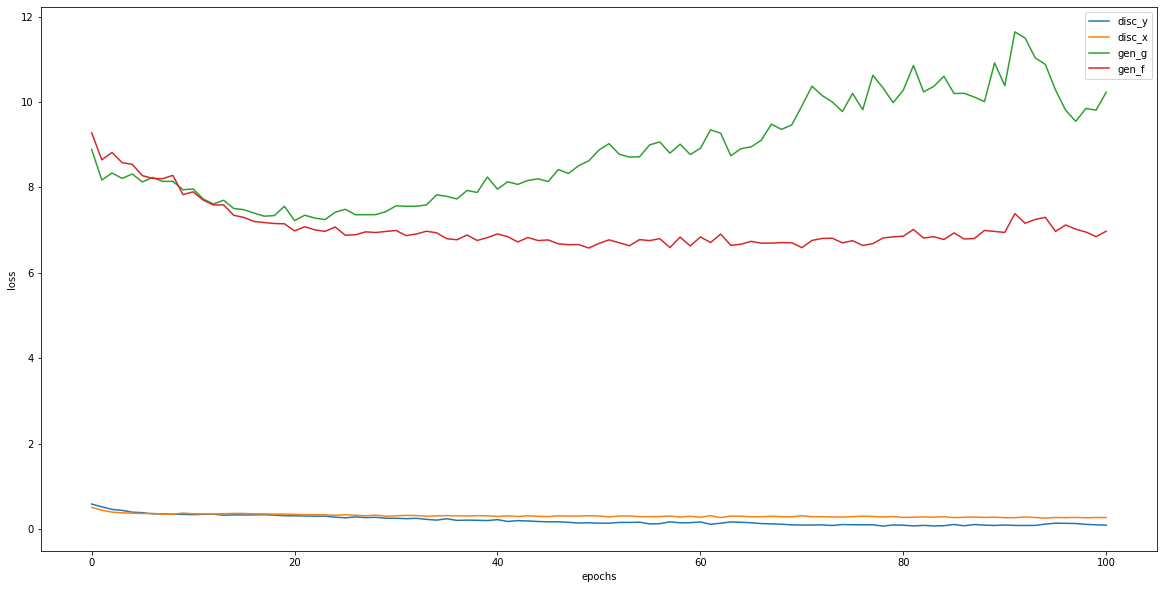

In [0]:
df_loss = pickle.load( open( "df_loss", "rb" ) )
x = np.arange(0,101)
plt.figure(figsize=(20,10))
plt.plot(x, df_loss.disc_y_loss)
plt.plot(x, df_loss.disc_x_loss)
plt.plot(x, df_loss.gen_g_loss)
plt.plot(x, df_loss.gen_f_loss)
plt.legend(["disc_y", "disc_x", "gen_g", "gen_f"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
plt.close()


In [0]:
df_loss

,disc_y_loss,gen_g_loss,disc_x_loss,gen_f_loss
0,0.588141,8.889,0.510231,9.28035
1,0.523564,8.1736,0.443975,8.64693
2,0.463005,8.33849,0.399273,8.82049
3,0.43963,8.21325,0.382907,8.58117
4,0.397723,8.31477,0.374909,8.54052
...,...,...,...,...
96,0.136481,9.80836,0.269127,7.12184
97,0.132738,9.54896,0.276178,7.02277
98,0.112184,9.85011,0.266809,6.95639
99,0.103243,9.8094,0.273753,6.8499


We show a few fixed images to show the progression of the model

![starting images](https://drive.google.com/uc?id=1iXLoTcUOxdt-TjJiSy2Dq-BNJpJov3wP) 

![Epoch0](https://drive.google.com/uc?id=1RAI3wvnjiintdIBhEj9D1FACQOWYbA7G) 

![Epoch10](https://drive.google.com/uc?id=1-2p5R38jFmhSoG2HB8A0DJEF3p_8SJfP) 

![Epoch20](https://drive.google.com/uc?id=1-6XYVzbAIHh_OTae0Vte89Vcm_Algk5U) 

![Epoch30](https://drive.google.com/uc?id=1-CuH7ZQEnp0A78AkQ1DEuWMeN89JDpcY) 

![Epoch40](https://drive.google.com/uc?id=1-FQGBiHS5-IDYYVtN76DNI7ooy2yKXRT) 

![Epoch50](https://drive.google.com/uc?id=1-JNcqRIPsaIAY2CkUn1pw_sfHV5Q0wo2)

![Epoch60](https://drive.google.com/uc?id=1-M3Iz-u8vbKXtD6yUSDvc3A5IHwoAcKv) 

![Epoch70](https://drive.google.com/uc?id=1-Qc_axBYCmUltEe-k7Qmilb1IjlPwrTs) 





We are quite satisfied with this 70th epoch. The center image shows a deer in the moutains, and these mountains seems to have taken the shape of 'la Danse' painting of Matisse. 


![Dance](https://drive.google.com/uc?id=13J2Q7hVtkH7z976aJkZ_Ir9rN76YIot0)

Then the model probably started another phase of learning : it didn't necessarly collapsed since the shapes are still different on images but the colors are quite similar. Longer training period could have helped, but we were already on a very long training. 



![Epoch80](https://drive.google.com/uc?id=1-UB6_VdI90Syt8AiWja0S4K-yEirgaXx)

![Epoch90](https://drive.google.com/uc?id=1-XM7ryZkWkyoDYL5fn57z64RkGxgrgxf)


![Epoch100](https://drive.google.com/uc?id=1-aZIZTAXLQr7miMaeqj4sJ9LzR_SlNio)
